# FM Demodulator on PYNQ

## Required Libraries

In this project, we use RTL2832 USB tuners to get our RF input samples. 
<img src="rtl2832.png" alt="RTL2832" style="width: 200px;"/>
In order to interact with this unit, you should install the following library:

https://pypi.org/project/pyrtlsdr/

In [ ]:
! pip3 install scikit-dsp-comm

## Testing the Unit

Connect your RF tuner to the board via the USB connector and run the following cells. 

In [1]:
from rtlsdr import *  # importing the library to interact with the RF tuner

sdr = RtlSdr()  # initializing an instance for the device

# configure device
sdr.sample_rate = 2.4e6  # reading 2.4M samples per second
sdr.center_freq = 94.1e6  # tuning to 94.1MHz
sdr.gain = 40.2

t_s = 1  # we read 1 second worth of samples
n_s = int(sdr.sample_rate)*t_s  # number of samples in 1 second

samples = sdr.read_samples(n_s)  # reading samples to the "samples" array
sdr.close()  # closing the device instance

In [ ]:
"""
Alternatively, You can load samples from the provided file. 
"""
import numpy as np
samples2 = np.load('samples.npy')

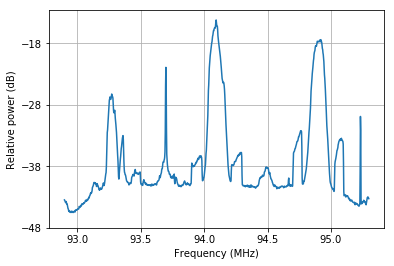

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
# use matplotlib to estimate and plot the PSD
plt.psd(samples, NFFT=1024, Fs=sdr.sample_rate/1e6, Fc=sdr.center_freq/1e6)
plt.xlabel('Frequency (MHz)')
plt.ylabel('Relative power (dB)')

plt.show()

## Demodulating the Signal

As you can see in the power spectral density plot, there is a strong signal at 94.1MHz. This is KMYI radio channel local to San Diego are.

We can install the following library to demodulate this FM signal:

https://pypi.org/project/scikit-dsp-comm/

In [ ]:
! pip3 install scikit-dsp-comm

The following cell can demodulate our RF samples stored in **samples** array

In [3]:
import sk_dsp_comm.rtlsdr_helper as sdr
from IPython.display import Audio
import time

#samples = sdr.capture(1, fo=94.1e6, fs=2.4e6, gain=40.2)  # we already captured our samples,
#                                                            this is an alternative way for 
#                                                            gathering samples using sk_dsp_comm library
tic = time.clock()
z_bb, z_out = sdr.mono_FM(samples, fs=2.4e6, file_name='SW.wav')  # this line demodulates the samples and stores 
toc = time.clock()
print("Proceesing time: {} seconds".format(toc - tic))
#                                                             the output in SW.wav

Audio('SW.wav')  # play the results using your laptop speaker

Done!
Proceesing time: 5.1691569999999984 seconds


## Digging Deeper into mono_FM

The source code for *mono_FM* is available at:
https://github.com/mwickert/scikit-dsp-comm/blob/master/sk_dsp_comm/rtlsdr_helper.py

The following cell is the implementation of mono_FM and its helper function, *discrim*. We have renamed these functions to xxx_impl.

In [4]:
import scipy.signal as signal
import numpy as np
import sk_dsp_comm.sigsys as ss

def discrim_impl(x):
    """
    function disdata = discrim(x)
    where x is an angle modulated signal in complex baseband form.
    
    Mark Wickert
    http://www.eas.uccs.edu/~mwickert/ece5625/lecture_notes/N5625_4.pdf page 4-23
    """
    X=np.real(x)        # X is the real part of the received signal
    Y=np.imag(x)        # Y is the imaginary part of the received signal
    b=np.array([1, -1]) # filter coefficients for discrete derivative
    a=np.array([1, 0])  # filter coefficients for discrete derivative
    derY=signal.lfilter(b,a,Y)  # derivative of Y, 
    derX=signal.lfilter(b,a,X)  #    "          X,
    disdata=(X*derY-Y*derX)/(X**2+Y**2)
    return disdata

def mono_FM_impl(x,fs=2.4e6,file_name='test.wav'):
    """
    Decimate complex baseband input by 10
    Design 1st decimation lowpass filter (f_c = 200 KHz)
    """
    b = signal.firwin(64,2*200e3/float(fs))
    # Filter and decimate (should be polyphase)
    y = signal.lfilter(b,1,x)
    z = ss.downsample(y,10)
    # Apply complex baseband discriminator
    z_bb = discrim_impl(z)
    # Design 2nd decimation lowpass filter (fc = 12 KHz)
    bb = signal.firwin(64,2*12e3/(float(fs)/10))
    # Filter and decimate
    zz_bb = signal.lfilter(bb,1,z_bb)
    # Decimate by 5
    z_out = ss.downsample(zz_bb,5)
    # Save to wave file
    ss.to_wav(file_name, 48000, z_out/2)
    print('Done!')
    return z_bb, z_out

In [ ]:
z_bb, z_out = mono_FM_impl(samples, fs=2.4e6, file_name='SW1.wav')
Audio('SW1.wav')

Finally, the implementation for *downsampe* is available at:

https://github.com/mwickert/scikit-dsp-comm/blob/master/sk_dsp_comm/sigsys.py#L2673

In [ ]:
def downsample_impl(x, M, p=0):  
    if not isinstance(M, int):
        raise TypeError("M must be an int")
    x = x[0:int(np.floor(len(x)/M))*M]
    x = x.reshape((int(np.floor(len(x)/M)),M))
    y = x[:,p]
    return y

def discrim_impl(x):
    """
    function disdata = discrim(x)
    where x is an angle modulated signal in complex baseband form.
    
    Mark Wickert
    """
    X=np.real(x)        # X is the real part of the received signal
    Y=np.imag(x)        # Y is the imaginary part of the received signal
    b=np.array([1, -1]) # filter coefficients for discrete derivative
    derY=signal.lfilter(b,1,Y)  # derivative of Y, 
    derX=signal.lfilter(b,1,X)  #    "          X,
    disdata=(X*derY-Y*derX)/(X**2+Y**2)
    return disdata

def mono_FM_impl(x,fs=2.4e6,file_name='test.wav'):
    """
    Decimate complex baseband input by 10
    Design 1st decimation lowpass filter (f_c = 200 KHz)
    """
    b = signal.firwin(64,2*200e3/float(fs))
    # Filter and decimate (should be polyphase)
    y = signal.lfilter(b,1,x)
    z = downsample_impl(y,10)
    # Apply complex baseband discriminator
    z_bb = discrim_impl(z)
    # Design 2nd decimation lowpass filter (fc = 12 KHz)
    bb = signal.firwin(64,2*12e3/(float(fs)/10))
    # Filter and decimate
    zz_bb = signal.lfilter(bb,1,z_bb)
    # Decimate by 5
    z_out = downsample_impl(zz_bb,5)
    # Save to wave file
    ss.to_wav(file_name, 48000, z_out/2)
    print('Done!')
    return z_bb, z_out

In [ ]:
z_bb, z_out = mono_FM_impl(samples, fs=2.4e6, file_name='SW2.wav')
Audio('SW2.wav')

## lfilter Function

lfilter function implementation is available at 

https://github.com/scipy/scipy/blob/v1.5.4/scipy/signal/signaltools.py#L1719-L1909

This filter function is implemented as a direct II transposed structure.

    This means that the filter implements:
       a[0]*y[n] = b[0]*x[n] + b[1]*x[n-1] + ... + b[M]*x[n-M]
                             - a[1]*y[n-1] - ... - a[N]*y[n-N]
                             
Since in all of our functions calls, we call this function as lfilter(b,1,x), the following *linear_function* is the simplified implementation that we need for *mono_FM*

In [27]:
def linear_filter(b, x):
    y = np.zeros_like(x)
    buff = np.zeros(b.shape, dtype=type(x[0]))
    b_len = len(buff)
    for i in range(len(y)):
        for j in range(b_len-1):
            buff[b_len-1-j] = buff[b_len-2-j]
        buff[0] = x[i]
        
        temp = 0
        for j in range(b_len):
            temp += buff[j]*b[j]
        y[i] = temp
    return y

def downsample_impl(x, M, p=0):  
    if not isinstance(M, int):
        raise TypeError("M must be an int")
    x = x[0:int(np.floor(len(x)/M))*M]
    x = x.reshape((int(np.floor(len(x)/M)),M))
    y = x[:,p]
    return y

def discrim_impl(x):
    """
    function disdata = discrim(x)
    where x is an angle modulated signal in complex baseband form.
    
    Mark Wickert
    """
    X=np.real(x)        # X is the real part of the received signal
    Y=np.imag(x)        # Y is the imaginary part of the received signal
    b=np.array([1, -1]) # filter coefficients for discrete derivative
    derY=linear_filter(b,Y)  # derivative of Y, 
    derX=linear_filter(b,X)  #    "          X,
    disdata=(X*derY-Y*derX)/(X**2+Y**2)
    return disdata

def mono_FM_impl(x,fs=2.4e6,file_name='test.wav'):
    """
    Decimate complex baseband input by 10
    Design 1st decimation lowpass filter (f_c = 200 KHz)
    """
    b = signal.firwin(64,2*200e3/float(fs))
    # Filter and decimate (should be polyphase)
    y = linear_filter(b,x)
    z = downsample_impl(y,10)
    # Apply complex baseband discriminator
    z_bb = discrim_impl(z)
    # Design 2nd decimation lowpass filter (fc = 12 KHz)
    bb = signal.firwin(64,2*12e3/(float(fs)/10))
    # Filter and decimate
    zz_bb = linear_filter(bb,z_bb)
    # Decimate by 5
    z_out = downsample_impl(zz_bb,5)
    # Save to wave file
    # ss.to_wav(file_name, 48000, z_out/2)
    print('Done!')
    return z_bb, z_out

In [28]:
tic = time.clock()
z_bb, z_out = mono_FM_impl(samples, fs=2.4e6, file_name='SW3.wav')
toc = time.clock()
print("Proceesing time: {} seconds".format(toc - tic))
Audio(z_out, rate=48000)

Done!
Proceesing time: 1416.990257 seconds


## PYNQ Implementation

In this section, we take a look at our function calls and their variables

### Input to FPGA

In [43]:
print(samples.shape, type(samples[0]))

(2400000,) <class 'numpy.complex128'>


Our samples are complex128 (64-bit real, 64-bit imaginary). We can convert it to complex64 using *samples.astype(np.complex64)*. We use this conversion later in the code.

### First call to linear_filter - coefficients

In [44]:
fs = 2.4e6
b = signal.firwin(64,2*200e3/float(fs))
print(b.shape, type(b[0]))

(64,) <class 'numpy.float64'>


**b** is an array of float64 with 64 elements. This can be hard-coded in the source code in Vivado-HLS

### First call to linear_filter - output

In [45]:
y = linear_filter(b,samples[0:128])
print(y.shape, type(y[0]))

(128,) <class 'numpy.complex128'>


output is the same size as input with complex variables

### First call to downsample - output

In [46]:
z = downsample_impl(y,10)
print(z.shape, type(z[0]))

(12,) <class 'numpy.complex128'>


with a downsampling rate of 10, output's size is 1/10 of input with same data type

### discrim - output

In [47]:
z_bb = discrim_impl(z)
print(z_bb.shape, type(z_bb[0]))

(12,) <class 'numpy.float64'>


*discrim* function accepts complex input and produces float outputs with the same length.

### Second call to linear_filter - coefficients

In [48]:
bb = signal.firwin(64,2*12e3/(float(fs)/10))
print(bb.shape, type(bb[0]))

(64,) <class 'numpy.float64'>


**bb** is an array of float64 with 64 elements. This can be hard-coded in the source code in Vivado-HLS

### Second call to linear_filter - output

In [49]:
zz_bb = linear_filter(bb,z_bb)
print(zz_bb.shape, type(zz_bb[0]))

(12,) <class 'numpy.float64'>


output is the same size as input with float variables

### Second call to downsample - FPGA output

In [50]:
z_out = downsample_impl(zz_bb,5)
print(z_out.shape, type(z_out[0]))

(2,) <class 'numpy.float64'>


with a downsampling rate of 5, output's size is 1/5 of input with same data type

### FPGA implementation

Similar to your OFDM design, you can implement *mono_FM* as following:

```
mono_fm(complex input, float output){
    
    lf1(complex input, complex output);  // first linear_filter
    downsample1(complex input, complex output); // first downsample
    discrim(complex input, float output);
    lf2(float input, float output); // second linear_filter
    downsample2(float input, float output); // second downsample
}
```

Possible optimizations:

* Dataflow

* Loop unrolling

* Pipelining

You have to create your own testbecnh and implement moono_FM in Vivado_HLS and then, using Vivado, you have to generate a working bitstream.


## Host Program

In the following, we walk you through a series of possible implementations and briefly discuss their performance.


### Using m_axi

*m_axi* has a simple implementation since it does not require a different data structure for the interface.
However, when using *m_axi*, host does not get notified when *reads* are done. The host program can only check the **ap_done** signal which indicates that the IP is done processing its input.
In this case, you cannot (safely) send the next input unless you receive an output. Which is not suitable for dataflow.

The following cell shows an example of *m_axi*, note its large processing time.

In [5]:
from pynq import Overlay
from pynq import Xlnk

ol = Overlay('mono_fm.bit')
ol.download()

In [6]:
mfm_ip = ol.mono_fm_0
length = 1000
length50 = 20
in_r = Xlnk().cma_array(shape=(length,), dtype=np.float32)
in_i = Xlnk().cma_array(shape=(length,), dtype=np.float32)
out_hw = Xlnk().cma_array(shape=(length50,), dtype=np.float32)
z_out_hw = np.zeros((2400*20,), dtype=np.float32)

tic = time.clock()
for i in range(2400):
    
    x = samples[i*1000:(i+1)*1000]
    x_hw = x.astype(np.complex64)
    
    np.copyto(in_r, np.real(x_hw))
    np.copyto(in_i, np.imag(x_hw))

    mfm_ip.write(0x10, in_r.physical_address)
    mfm_ip.write(0x18, in_i.physical_address)
    mfm_ip.write(0x20, out_hw.physical_address)
    mfm_ip.write(0x00, 1)
    while not (mfm_ip.read(0x00)&0x2):
        pass
    np.copyto(z_out_hw[i*20:(i+1)*20], out_hw)
    
    in_r.flush()
    in_i.flush()
    out_hw.flush()
toc = time.clock()
print("Proceesing time: {} seconds".format(toc - tic))

in_r.close()
in_i.close()
out_hw.close()

Proceesing time: 74.780022 seconds


In [7]:
Audio(z_out_hw, rate=48000)

### Using axis

Using the DMA library with *axis* interface, host can check the **reads** with **sendchannel.wait()** function.
By using asyncio, we can create two separate threads for *reads* and *writes*. The following host example shows an example.

In [15]:
ol = Overlay('mono_fm_dma.bit')
ol.download()

In [16]:
import asyncio
import pynq.lib.dma

mfm_ip = ol.mono_fm_0
dma_ro = ol.axi_dma_r
dma_i = ol.axi_dma_i

length = 1000
length50 = 20
in_r = Xlnk().cma_array(shape=(length,), dtype=np.float32)
in_i = Xlnk().cma_array(shape=(length,), dtype=np.float32)
out_hw = Xlnk().cma_array(shape=(length50,), dtype=np.float32)
z_out_hw = np.zeros((2400*20,), dtype=np.float32)

async def write_ip():
    
    for i in range(2400):
        x = samples[i*1000:(i+1)*1000]
        x_hw = x.astype(np.complex64)

        np.copyto(in_r, np.real(x_hw))
        np.copyto(in_i, np.imag(x_hw))

        dma_ro.sendchannel.transfer(in_r)
        dma_i.sendchannel.transfer(in_i)

        mfm_ip.write(0x00, 1)

        dma_ro.sendchannel.wait()
        dma_i.sendchannel.wait()
        
        await asyncio.sleep(0.000001)

        in_r.flush()
        in_i.flush()

async def read_ip():
    
    for i in range(2400):
        dma_ro.recvchannel.transfer(out_hw)
        dma_ro.recvchannel.wait()
        await asyncio.sleep(0.000001)

        np.copyto(z_out_hw[i*20:(i+1)*20], out_hw)
        out_hw.flush()

loop = asyncio.get_event_loop()
write_task = asyncio.ensure_future(write_ip())
read_task = asyncio.ensure_future(read_ip())

tic = time.clock()
loop.run_until_complete(read_task)
toc = time.clock()
print("Proceesing time: {} seconds".format(toc - tic))

# Removing the IP task from the event loop.
write_task.cancel()
in_r.close()
in_i.close()
out_hw.close()

Proceesing time: 73.60929999999999 seconds


In [17]:
Audio(z_out_hw, rate=48000)

### Improving the host for axis interface

The prcess time shown above, is not better than what we got with *m_axi*. The *wait()* functions are blocking functions and we have a large overhead. We can replace the *wait()* functions by a while loop for checking if the channel is idel.
The following cell shows an example. Note the improvement in processing time.

In [18]:
ol = Overlay('mono_fm_dma.bit')
ol.download()

In [19]:
import asyncio
import pynq.lib.dma

mfm_ip = ol.mono_fm_0
dma_ro = ol.axi_dma_r
dma_i = ol.axi_dma_i

length = 1000
length50 = 20
in_r = Xlnk().cma_array(shape=(length,), dtype=np.float32)
in_i = Xlnk().cma_array(shape=(length,), dtype=np.float32)
out_hw = Xlnk().cma_array(shape=(length50,), dtype=np.float32)
z_out_hw = np.zeros((2400*20,), dtype=np.float32)

async def write_ip():
    
    for i in range(2400):
        x = samples[i*1000:(i+1)*1000]
        x_hw = x.astype(np.complex64)

        np.copyto(in_r, np.real(x_hw))
        np.copyto(in_i, np.imag(x_hw))

        dma_ro.sendchannel.transfer(in_r)
        dma_i.sendchannel.transfer(in_i)

        mfm_ip.write(0x00, 1)

        while not dma_i.sendchannel.idle:
            await asyncio.sleep(0.000001)

        in_r.flush()
        in_i.flush()

async def read_ip():
    
    for i in range(2400):
        dma_ro.recvchannel.transfer(out_hw)
        
        while not dma_ro.recvchannel.idle:
            await asyncio.sleep(0.000001)

        np.copyto(z_out_hw[i*20:(i+1)*20], out_hw)
        out_hw.flush()

loop = asyncio.get_event_loop()
write_task = asyncio.ensure_future(write_ip())
read_task = asyncio.ensure_future(read_ip())

tic = time.clock()
loop.run_until_complete(read_task)
toc = time.clock()
print("Proceesing time: {} seconds".format(toc - tic))

# Removing the IP task from the event loop.
write_task.cancel()
in_r.close()
in_i.close()
out_hw.close()

Proceesing time: 64.107959 seconds


In [20]:
Audio(z_out_hw, rate=48000)

### Another try to improving the host for axis interface

Instead of starting our IP via the *s_axilite* interface, in vivado, we can connect this signal to a constant block similar to [lab2](https://pp4fpgas.readthedocs.io/en/latest/axidma.html).
Although we save one instruction, the improvement is negligible.

In [21]:
ol = Overlay('mono_fm_dma_fixed.bit')
ol.download()

In [22]:
import asyncio
import pynq.lib.dma

dma_ro = ol.axi_dma_r
dma_i = ol.axi_dma_i

length = 1000
length50 = 20
in_r = Xlnk().cma_array(shape=(length,), dtype=np.float32)
in_i = Xlnk().cma_array(shape=(length,), dtype=np.float32)
out_hw = Xlnk().cma_array(shape=(length50,), dtype=np.float32)
z_out_hw = np.zeros((2400*20,), dtype=np.float32)

async def write_ip():
    
    for i in range(2400):
        x = samples[i*1000:(i+1)*1000]
        x_hw = x.astype(np.complex64)

        np.copyto(in_r, np.real(x_hw))
        np.copyto(in_i, np.imag(x_hw))

        dma_ro.sendchannel.transfer(in_r)
        dma_i.sendchannel.transfer(in_i)
        
        # we do not need to execute mfm_ip.write(0x00, 1)

        while not dma_i.sendchannel.idle:
            await asyncio.sleep(0.000000001)

        in_r.flush()
        in_i.flush()

async def read_ip():
    
    for i in range(2400):
        dma_ro.recvchannel.transfer(out_hw)
        
        while not dma_ro.recvchannel.idle:
            await asyncio.sleep(0.000000001)

        np.copyto(z_out_hw[i*20:(i+1)*20], out_hw)
        out_hw.flush()

loop = asyncio.get_event_loop()
write_task = asyncio.ensure_future(write_ip())
read_task = asyncio.ensure_future(read_ip())

tic = time.clock()
loop.run_until_complete(read_task)
toc = time.clock()
print("Proceesing time: {} seconds".format(toc - tic))

# Removing the IP task from the event loop.
write_task.cancel()
in_r.close()
in_i.close()
out_hw.close()

Proceesing time: 64.08997900000003 seconds


In [23]:
Audio(z_out_hw, rate=48000)

### Streaming all the data

In our previous examples, we had to send and receive many chunks of data (2400 of them). This is a large overhead for initializing DMAs, transmitting the data, and waiting for each transmission.

We can change it to a one time transmittion. However, we cannot store all the data in our FPGA at once, therefore, we have to stream the data, and process it in chuncks.

In this design, the HLS implementation reads 1000 inputs, processes it and writes the results to the output DMA. It repeats this process for 2400 times. The last bit (used for indicating the last output for DMA) is only set to 1 for the very last output of the last chunck (2400th output).

By applying proper optimizations, the IP can read new inputs (1000 at the time) with a small interval and using dataflow, a stream of outputs can be generated.

The following cells show an example for such an IP. Note the improvement in the procesing time.

In [24]:
ol = Overlay('mono_fm_dma_fast.bit')
ol.download()

In [25]:
dma_ro = ol.axi_dma_r
dma_i = ol.axi_dma_i

length = 1000*2400
length50 = 20*2400
in_r = Xlnk().cma_array(shape=(length,), dtype=np.float32)
in_i = Xlnk().cma_array(shape=(length,), dtype=np.float32)
out_hw = Xlnk().cma_array(shape=(length50,), dtype=np.float32)

tic = time.clock()    
x_hw = samples.astype(np.complex64)

np.copyto(in_r, np.real(x_hw))
np.copyto(in_i, np.imag(x_hw))

dma_ro.sendchannel.transfer(in_r)
dma_i.sendchannel.transfer(in_i)
dma_ro.recvchannel.transfer(out_hw)

dma_ro.sendchannel.wait()
dma_i.sendchannel.wait()
dma_ro.recvchannel.wait()

toc = time.clock()
print("Proceesing time: {} seconds".format(toc - tic))

in_r.close()
in_i.close()
out_hw.close()

Proceesing time: 0.9370569999999816 seconds


In [26]:
Audio(out_hw, rate=48000)

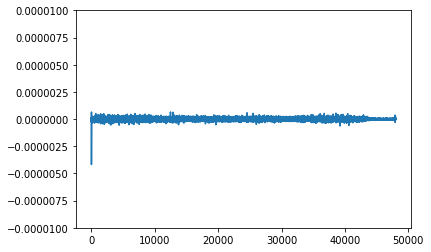

RMSE: 8.434689546436835e-08


In [37]:
""" Calculating and plotting Error"""
%matplotlib inline
diff = z_out - out_hw
plt.plot(diff)
plt.ylim((-0.00001, 0.00001))
plt.show()
print("RMSE: {}".format(np.sqrt(np.mean((diff)**2))))